<a href="https://colab.research.google.com/github/ritwiks9635/ML_Search_Engine/blob/main/Image_Search_Description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Query Image Search Description**

[Dataset](https://www.kaggle.com/datasets/arnaud58/landscape-pictures)

In [2]:
import zipfile

# Specify the zip file path and the extraction directory
zip_file_path = "/content/https:/www.kaggle.com/datasets/arnaud58/landscape-pictures/landscape-pictures.zip"
extract_to = "/content/images/"

# Open the zip file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_to)

print("Extraction complete!")

Extraction complete!


In [3]:
print(len(os.listdir("/content/images")))

4319


```
!pip install sentence_transformers

!pip install google-generativeai
```

In [11]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image as Img
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image, Markdown
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)

In [ ]:
model = SentenceTransformer('clip-ViT-B-32')

In [8]:
img_dir = "/content/images"

In [9]:
img_path = list(glob.glob("/content/images/*.jpg"))[:1000]
print("Total Images ::", len(img_path))

Total Images :: 1000


In [12]:
img_embedd = model.encode([Img.open(path) for path in img_path], batch_size = 128, convert_to_tensor = True, show_progress_bar = True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [34]:
def SearchImages(query, k = 1):
    query_embedd = model.encode(query, convert_to_tensor = True, show_progress_bar =True)

    preds = util.semantic_search(query_embedd, img_embedd, top_k = k)[0]

    print("Query")
    display(query)

    for pred in preds:
        display(Image(os.path.join(img_dir, img_path[pred['corpus_id']]), width=500,height=500))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query


'the house in mountain'

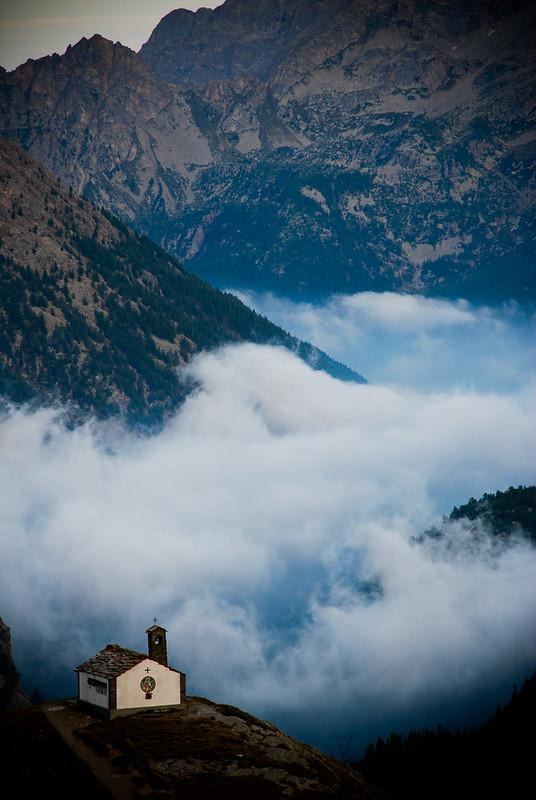

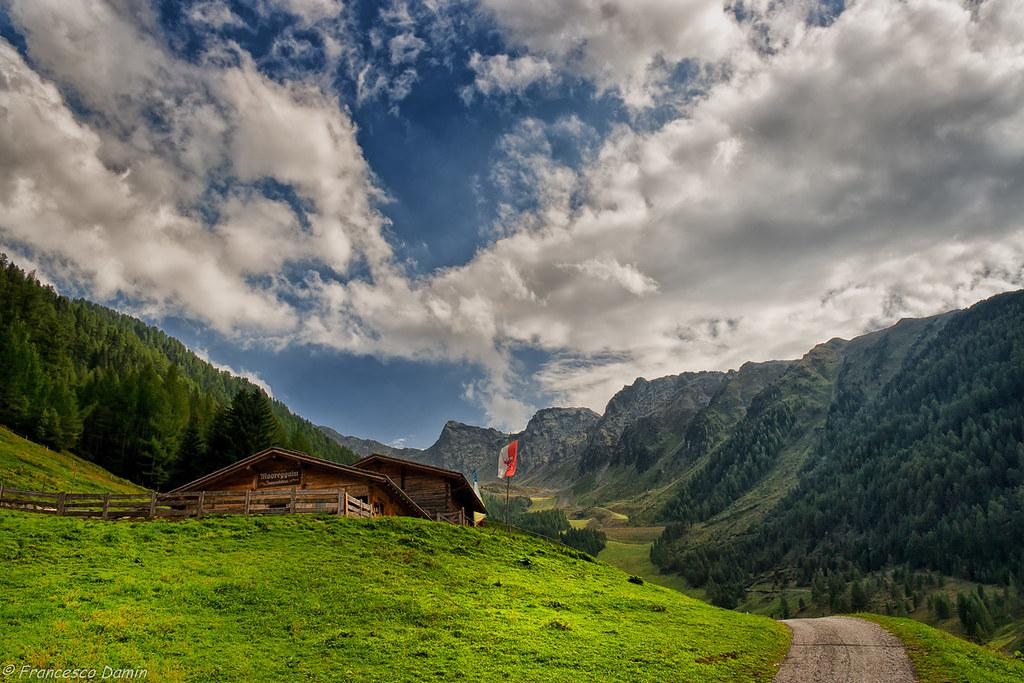

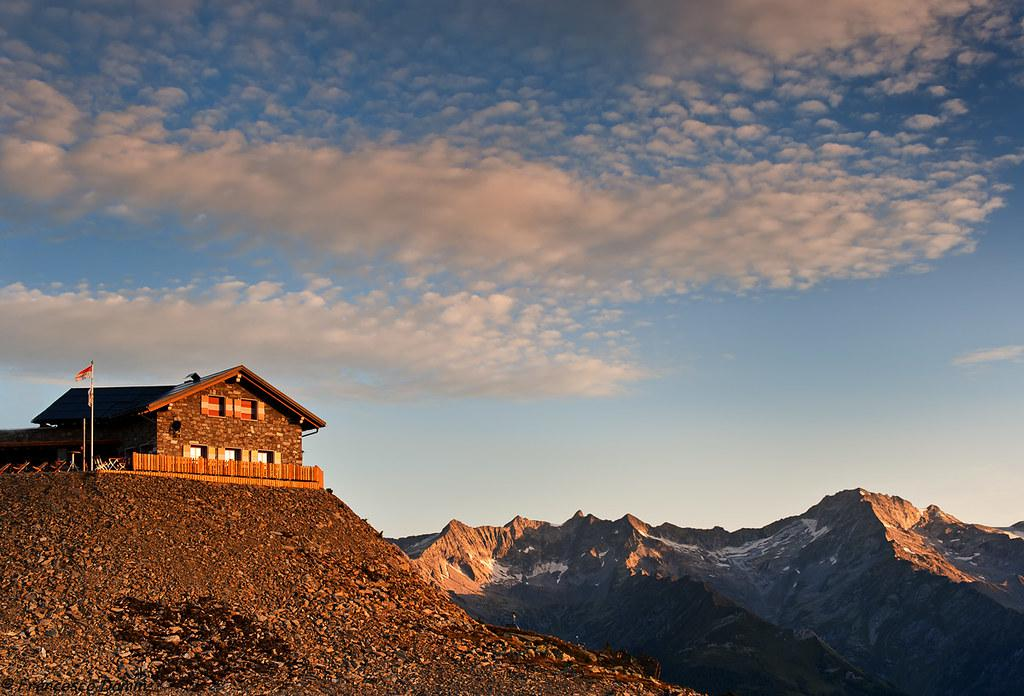

In [16]:
SearchImages("the house in mountain", k = 3)

In [24]:
googlai_api_keys = "keys"

In [29]:
import google.generativeai as genai
from google.api_core.client_options import ClientOptions

# Set the Vision model key
genai.configure(
        api_key = googlai_api_keys,
        transport="rest",
        client_options=ClientOptions(
            api_endpoint=os.getenv("GOOGLE_API_BASE"),
        ),
)

In [30]:
import textwrap

def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

def call_LMM(image_path: str, prompt: str) -> str:
    img = Img.open(image_path)

    model = genai.GenerativeModel("gemini-pro-vision")
    response = model.generate_content([prompt, img], stream=True)
    response.resolve()

    return to_markdown(response.text)

In [20]:
p = os.listdir(img_dir)[0]
img_p = os.path.join(img_dir, p)

In [31]:
call_LMM(img_p, "Please describe this image in detail.")

>  The image shows a view of Mount Fuji from Lake Ashi in Hakone, Kanagawa Prefecture, Japan. The sky is cloudy and the lake is calm. There are some trees on the shore of the lake and a few buildings can be seen in the distance. The mountain is covered in snow.

In [44]:
def SearchImages_Disc(query, k = 1):
    query_embedd = model.encode(query, convert_to_tensor = True, show_progress_bar =True)

    preds = util.semantic_search(query_embedd, img_embedd, top_k = k)[0]

    for pred in preds:
        pred_img = os.path.join(img_dir, img_path[pred['corpus_id']])
        display(Image(pred_img , width=500,height=500))

        description = call_LMM(pred_img, "Please describe this image in detail.")
        display(description)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

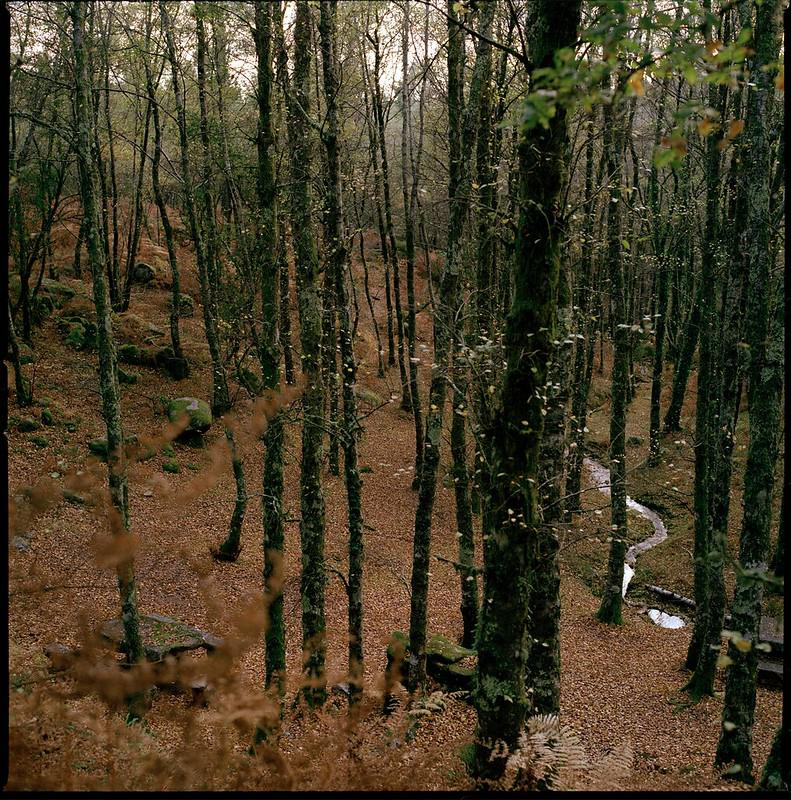

>  The image is a photograph of a forest. The trees are tall and straight, with thick trunks and branches. The leaves on the trees are a mix of green, yellow, and brown. The ground is covered in a thick layer of leaves. There is a small stream running through the forest. The stream is surrounded by rocks and moss. There is a bench next to the stream. The bench is made of wood and is painted green. There is a picnic table next to the bench. The picnic table is made of wood and is painted blue.

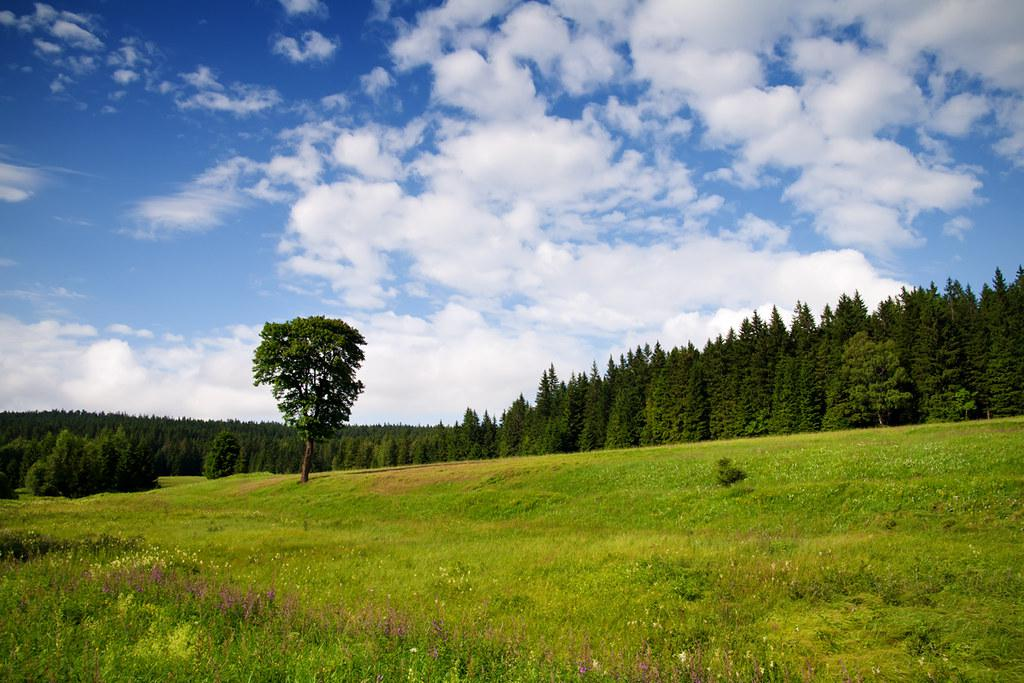

>  The image shows a green field on a sunny day. There is a large tree in the middle of the field, and a forest of dark green trees in the background. The sky is blue and there are some white clouds in the sky. There are also some flowers in the field.

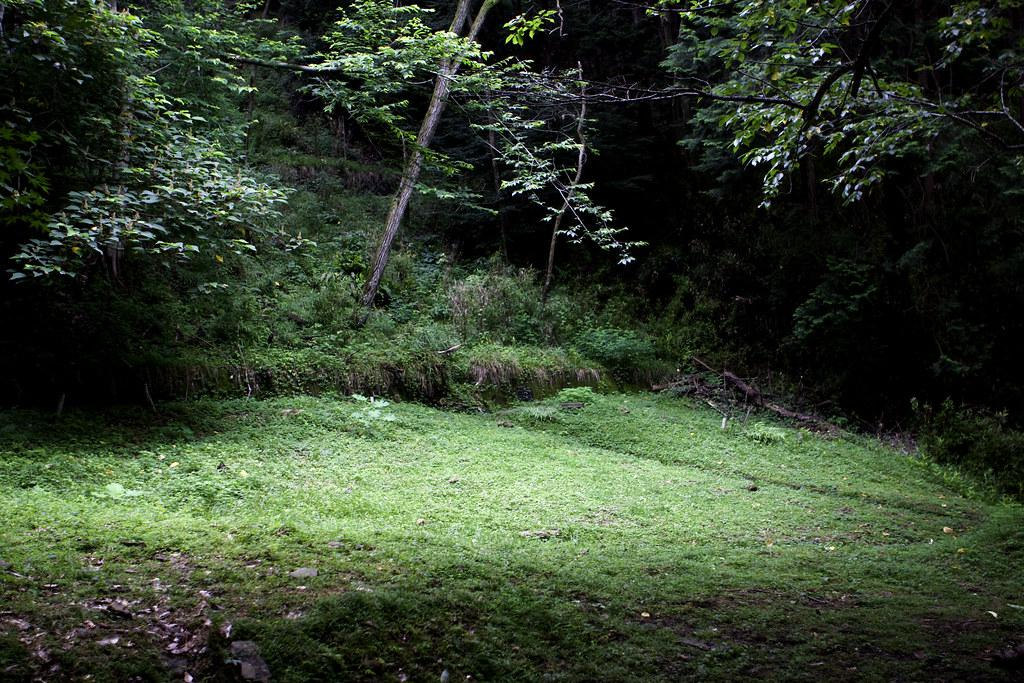

>  This image is a photograph of a forest clearing. The clearing is surrounded by tall trees and dense vegetation. The ground is covered in a thick layer of moss. There is a large tree stump in the center of the clearing. The trees in the background are partially obscured by a low-hanging canopy of leaves. The overall effect of the image is one of mystery and intrigue. It is unclear what lies beyond the clearing, and the dense vegetation suggests that the area is unexplored. The image is also quite dark, which adds to the sense of mystery.

In [45]:
SearchImages_Disc("the green forest", k = 3)